In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tqdm

tqdm.tqdm.pandas()
import io
import gzip
import pytricia

def coalesce_into_other(df, K, val_col, *indices):
    return pd.concat([
        df.sort_values(val_col, ascending=False).iloc[:K][[*indices, val_col]],
        pd.DataFrame(columns=[*indices, val_col], 
                  data = [[
                      *['Other' for _ in indices],
                      df.sort_values(val_col, ascending=False).iloc[15:][val_col].sum(),
                  ]])
    ])

f = display
f = lambda x: print(
    x.style
    .hide(axis='index')
    .format_index(axis=0, escape='latex')
    .format_index(axis=1, escape='latex')
    .to_latex()
)

# Question 1

In [62]:
df = pd.read_csv('data/processed/volume_by_protocol_port.csv')

f(
    df
    .groupby(['Protocol'])
    [['RelativeCount', 'RelativeVolume']]
    .sum()
    .reset_index()
    .sort_values('RelativeVolume', ascending=False)
    .head(20)
)
f(
    df
    .groupby(['Protocol', 'Port'])
    [['RelativeCount', 'RelativeVolume']]
    .sum()
    .reset_index()
    .sort_values('RelativeVolume', ascending=False)
    .head(20)
)

\begin{tabular}{lrr}
Protocol & RelativeCount & RelativeVolume \\
UDP & 0.584377 & 0.700904 \\
TCP & 0.407300 & 0.289160 \\
ICMPv4 & 0.003145 & 0.002443 \\
UnknownIPProtocol & 0.000081 & 0.000056 \\
GRE & 0.000000 & 0.000044 \\
IPv6 & 0.000001 & 0.000001 \\
IPv6HopByHop & 0.000001 & 0.000001 \\
IGMP & 0.000000 & 0.000000 \\
\end{tabular}

\begin{tabular}{lrrr}
Protocol & Port & RelativeCount & RelativeVolume \\
UDP & 53 & 0.550430 & 0.625467 \\
TCP & 23 & 0.045570 & 0.031654 \\
UDP & 5060 & 0.002901 & 0.013837 \\
TCP & 6379 & 0.014232 & 0.012064 \\
TCP & 22 & 0.016018 & 0.011441 \\
TCP & 8443 & 0.007263 & 0.005039 \\
TCP & 25 & 0.005479 & 0.004621 \\
TCP & 80 & 0.005250 & 0.004273 \\
TCP & 5555 & 0.004631 & 0.003374 \\
UDP & 443 & 0.000241 & 0.003104 \\
TCP & 3389 & 0.003963 & 0.002776 \\
UDP & 3702 & 0.003255 & 0.002614 \\
TCP & 81 & 0.003463 & 0.002409 \\
TCP & 443 & 0.003100 & 0.002252 \\
ICMPv4 & 2048 & 0.002965 & 0.002244 \\
TCP & 8080 & 0.003122 & 0.002204 \\
TCP & 53 & 0.002528 

# Question 2

In [71]:

as_numbers = io.StringIO()
as_org = io.StringIO()

with gzip.open('data/20230101.as-org2info.txt.gz') as file:
    while (line:=file.readline().decode('utf-8')):
        if 'format:' in line:
            as_org.write(line.replace('# format:', ''))
            break

    while (line:=file.readline().decode('utf-8')):
        if 'format:' in line:
            as_numbers.write(line.replace('# format:', ''))
            break
        as_org.write(line)

    while (line:=file.readline().decode('utf-8')):
        as_numbers.write(line)

    as_org.seek(0)
    as_numbers.seek(0)

as_orgs = pd.read_csv(as_org, delimiter='|')
as_numbers = pd.read_csv(as_numbers, delimiter='|')

as_org_data = as_orgs.merge(as_numbers, on='org_id', suffixes=['_org', '_number'])

df = pd.read_csv('data/processed/volume_by_source_as.csv').dropna()

df['SrcASN'] = df.SrcASN.str.split(',|_', regex=True).str[0].dropna().astype(int)
f(
    df
    .merge(
        as_org_data[['aut', 'org_name', 'country']], 
        left_on='SrcASN', 
        right_on='aut'
    ).drop(columns='aut')
    .head(10)
)


df = pd.read_csv('data/processed/volume_by_source_country.csv').dropna()
f(
    df
    .drop(columns=['MaxmindCountry'])
    .groupby('NetacqCountry')
    .sum()
    .reset_index()
    .sort_values('RelativeVolume', ascending=False)
    .head(10)
)

\begin{tabular}{rrrrrll}
SrcASN & Count & Volume & RelativeCount & RelativeVolume & org\_name & country \\
24560 & 8903109 & 879783558 & 0.261711 & 0.298629 & Bharti Airtel Limited & IN \\
9498 & 3447851 & 328159979 & 0.101351 & 0.111389 & Bharti Airtel Limited & IN \\
55836 & 3423046 & 339005780 & 0.100622 & 0.115070 & Reliance Jio Infocomm Limited & IN \\
202425 & 1984671 & 120963113 & 0.058340 & 0.041059 & IP Volume inc & SC \\
16509 & 1490310 & 136564084 & 0.043808 & 0.046355 & Amazon.com, Inc. & US \\
16509 & 9 & 540 & 0.000000 & 0.000000 & Amazon.com, Inc. & US \\
14061 & 1153173 & 73406305 & 0.033898 & 0.024917 & DigitalOcean, LLC & US \\
57523 & 563559 & 33813540 & 0.016566 & 0.011477 & Chang Way Technologies Co. Limited & HK \\
398324 & 556001 & 33955571 & 0.016344 & 0.011526 & Censys, Inc. & US \\
44446 & 512755 & 30765300 & 0.015073 & 0.010443 & OOO SibirInvest & RU \\
\end{tabular}

\begin{tabular}{lrrrr}
NetacqCountry & Count & Volume & RelativeCount & RelativeVolume \\
in

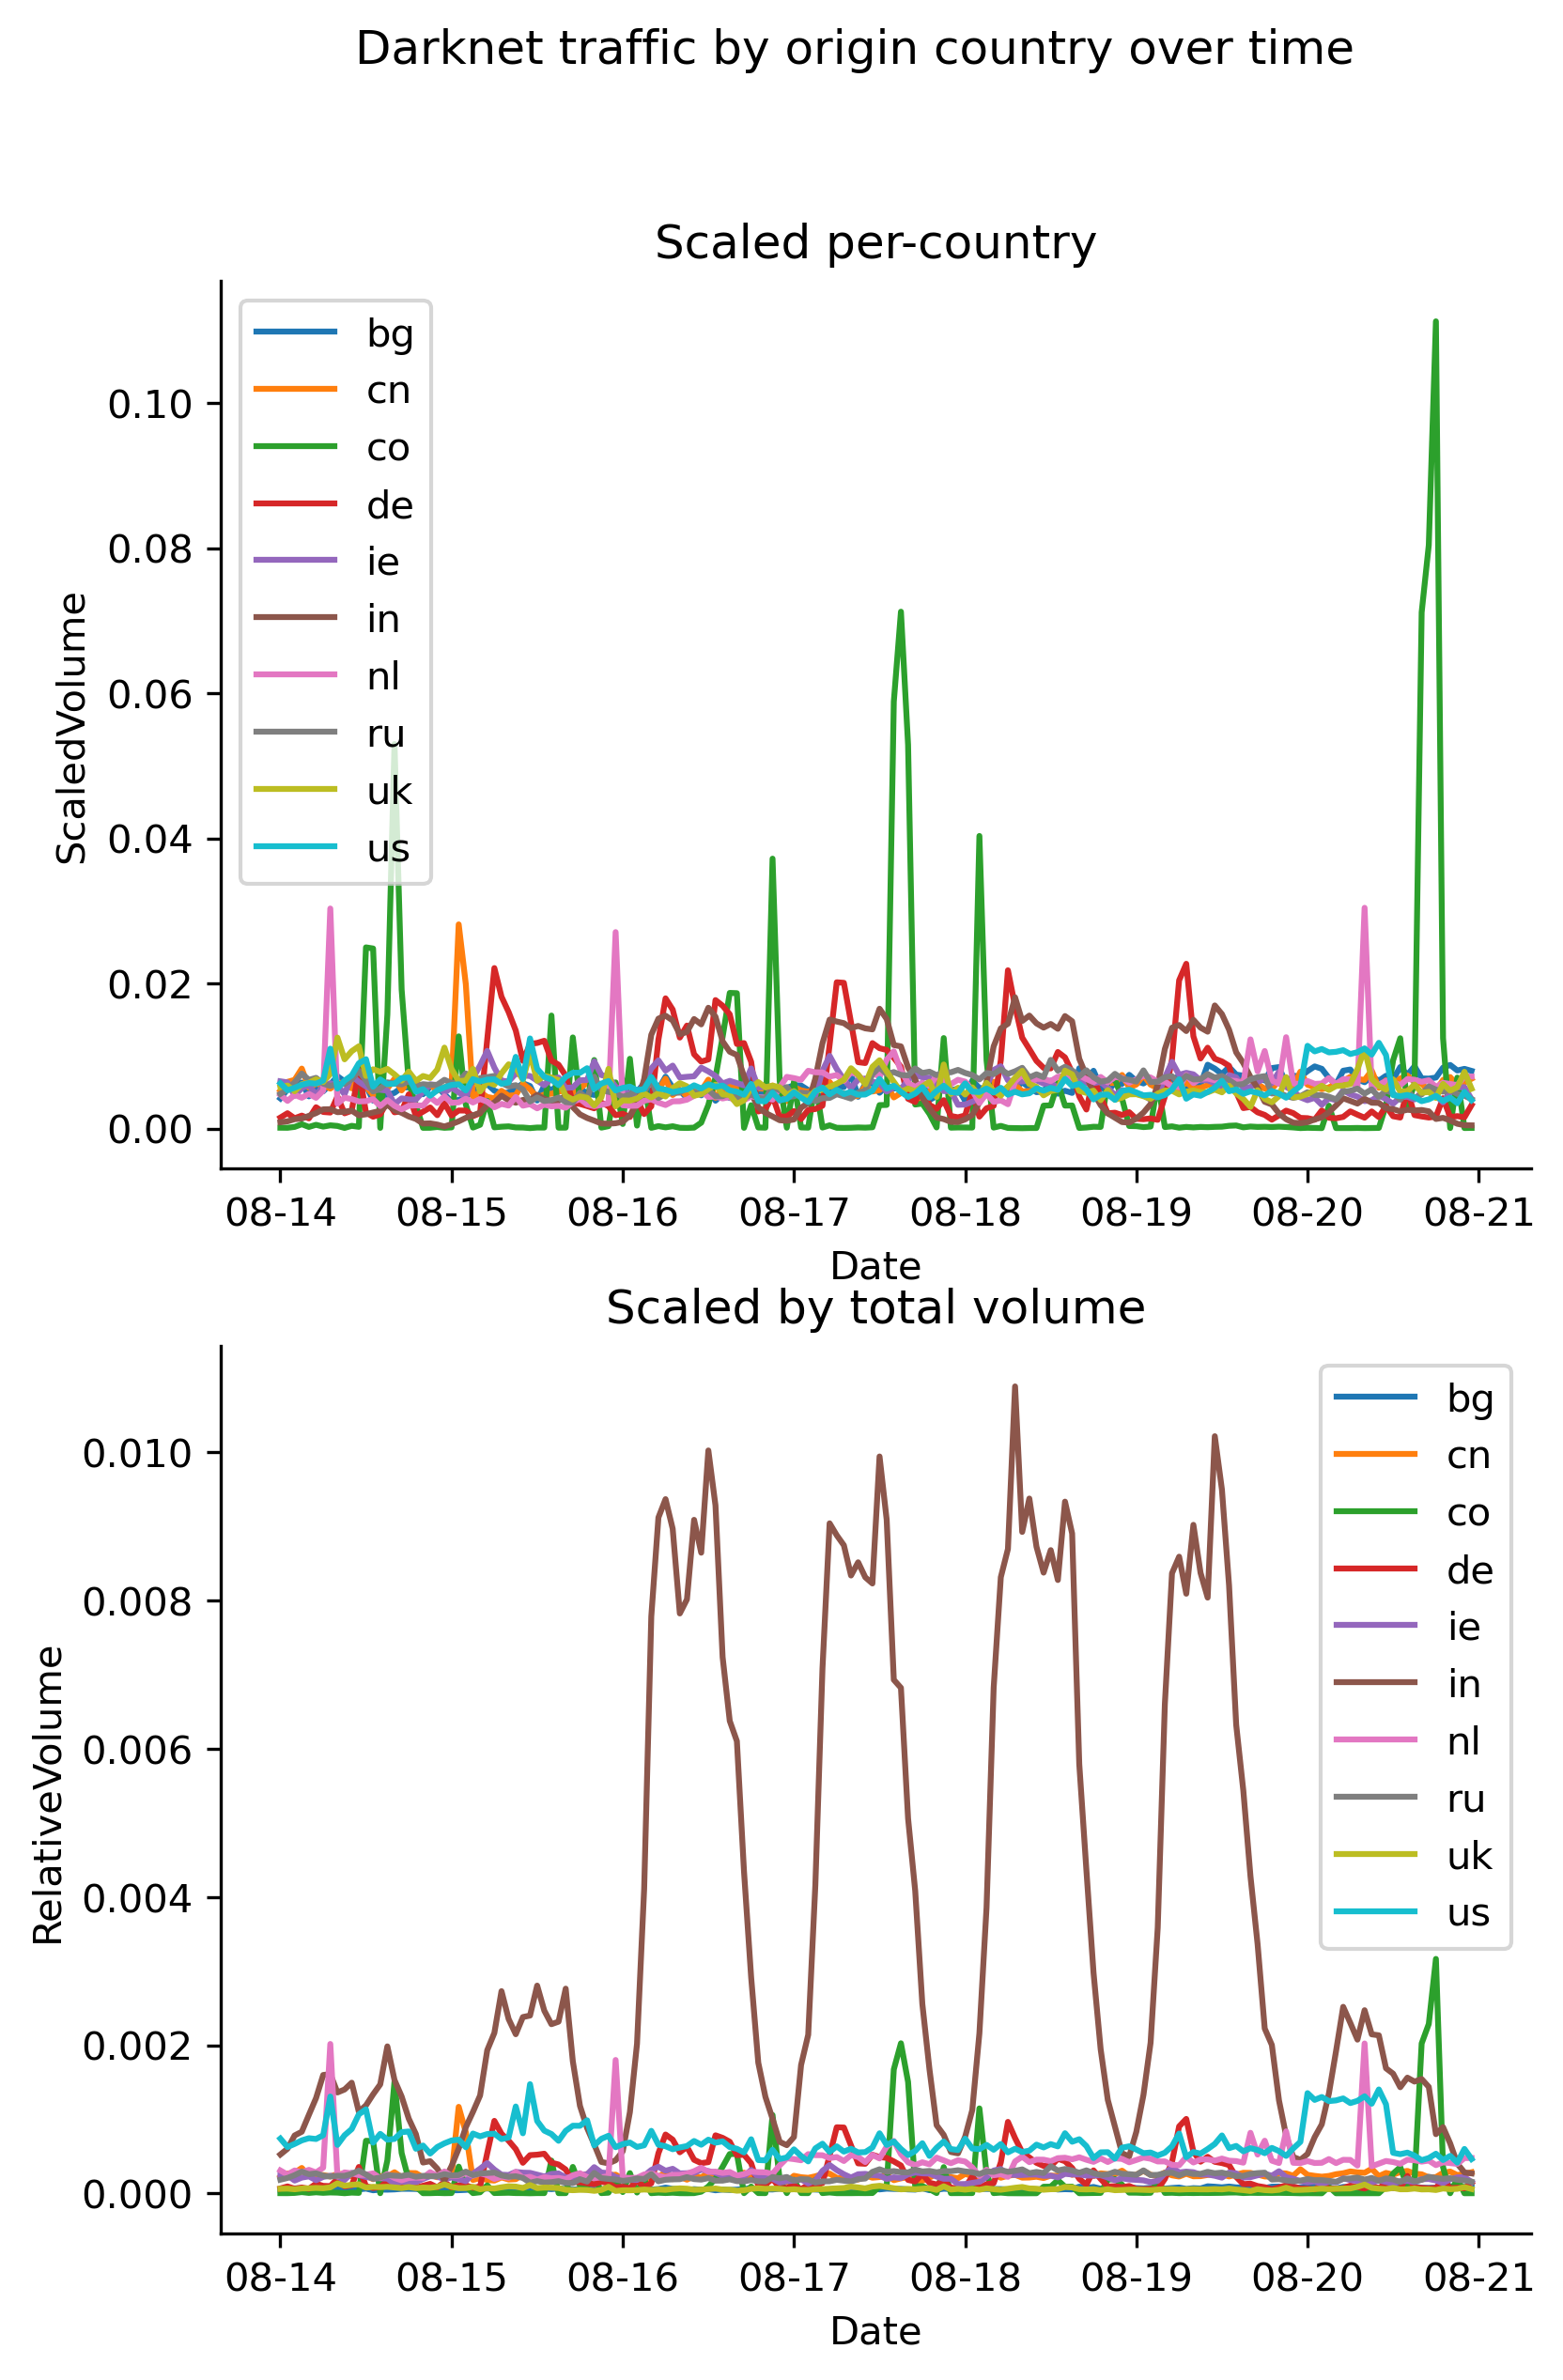

In [74]:

K = 10

# FOR TIMESERIES DF
fmt = '%Y-%m-%d %H:%M:%S %z'
df = pd.read_csv('data/processed/time_series_hour_country.csv')
df.Date = pd.to_datetime(df.Date.str[:-4], format=fmt).dt.tz_convert(None)
df = (
    df
    .groupby(['NetacqCountry', 'Date'], group_keys=False)['Volume']
    .sum()
    .reset_index()
)

top_K_countries = df.groupby('NetacqCountry')['Volume'].sum().sort_values(ascending=False)[:K].index

df = df[df.NetacqCountry.isin(top_K_countries)][['Date', 'NetacqCountry', 'Volume']]

t = df.groupby('NetacqCountry',group_keys=False)['Volume'].sum()

df['ScaledVolume'] = (
    df
    .groupby('NetacqCountry',group_keys=False)['Volume']
    .apply(lambda x: x / x.sum())
)

df['RelativeVolume'] = df['Volume'] / df['Volume'].sum()

fig, axes = plt.subplots(2,1, figsize=(6,9), dpi=300)

fig.suptitle('Darknet traffic by origin country over time')

for axis, column, title in zip(
    axes,
    ['ScaledVolume', 'RelativeVolume'],
    ['Scaled per-country', 'Scaled by total volume']
):
    sns.lineplot(
        ax=axis,
        data = df,
        x='Date',
        y=column,
        hue='NetacqCountry',
    )
    
    axis.set_title(title)
    axis.set_xticks(axis.get_xticks())
    axis.set_xticklabels([f'{i.get_text()[5:]}' for i in axis.get_xticklabels()])
    sns.despine(ax=axis)
    axis.legend()

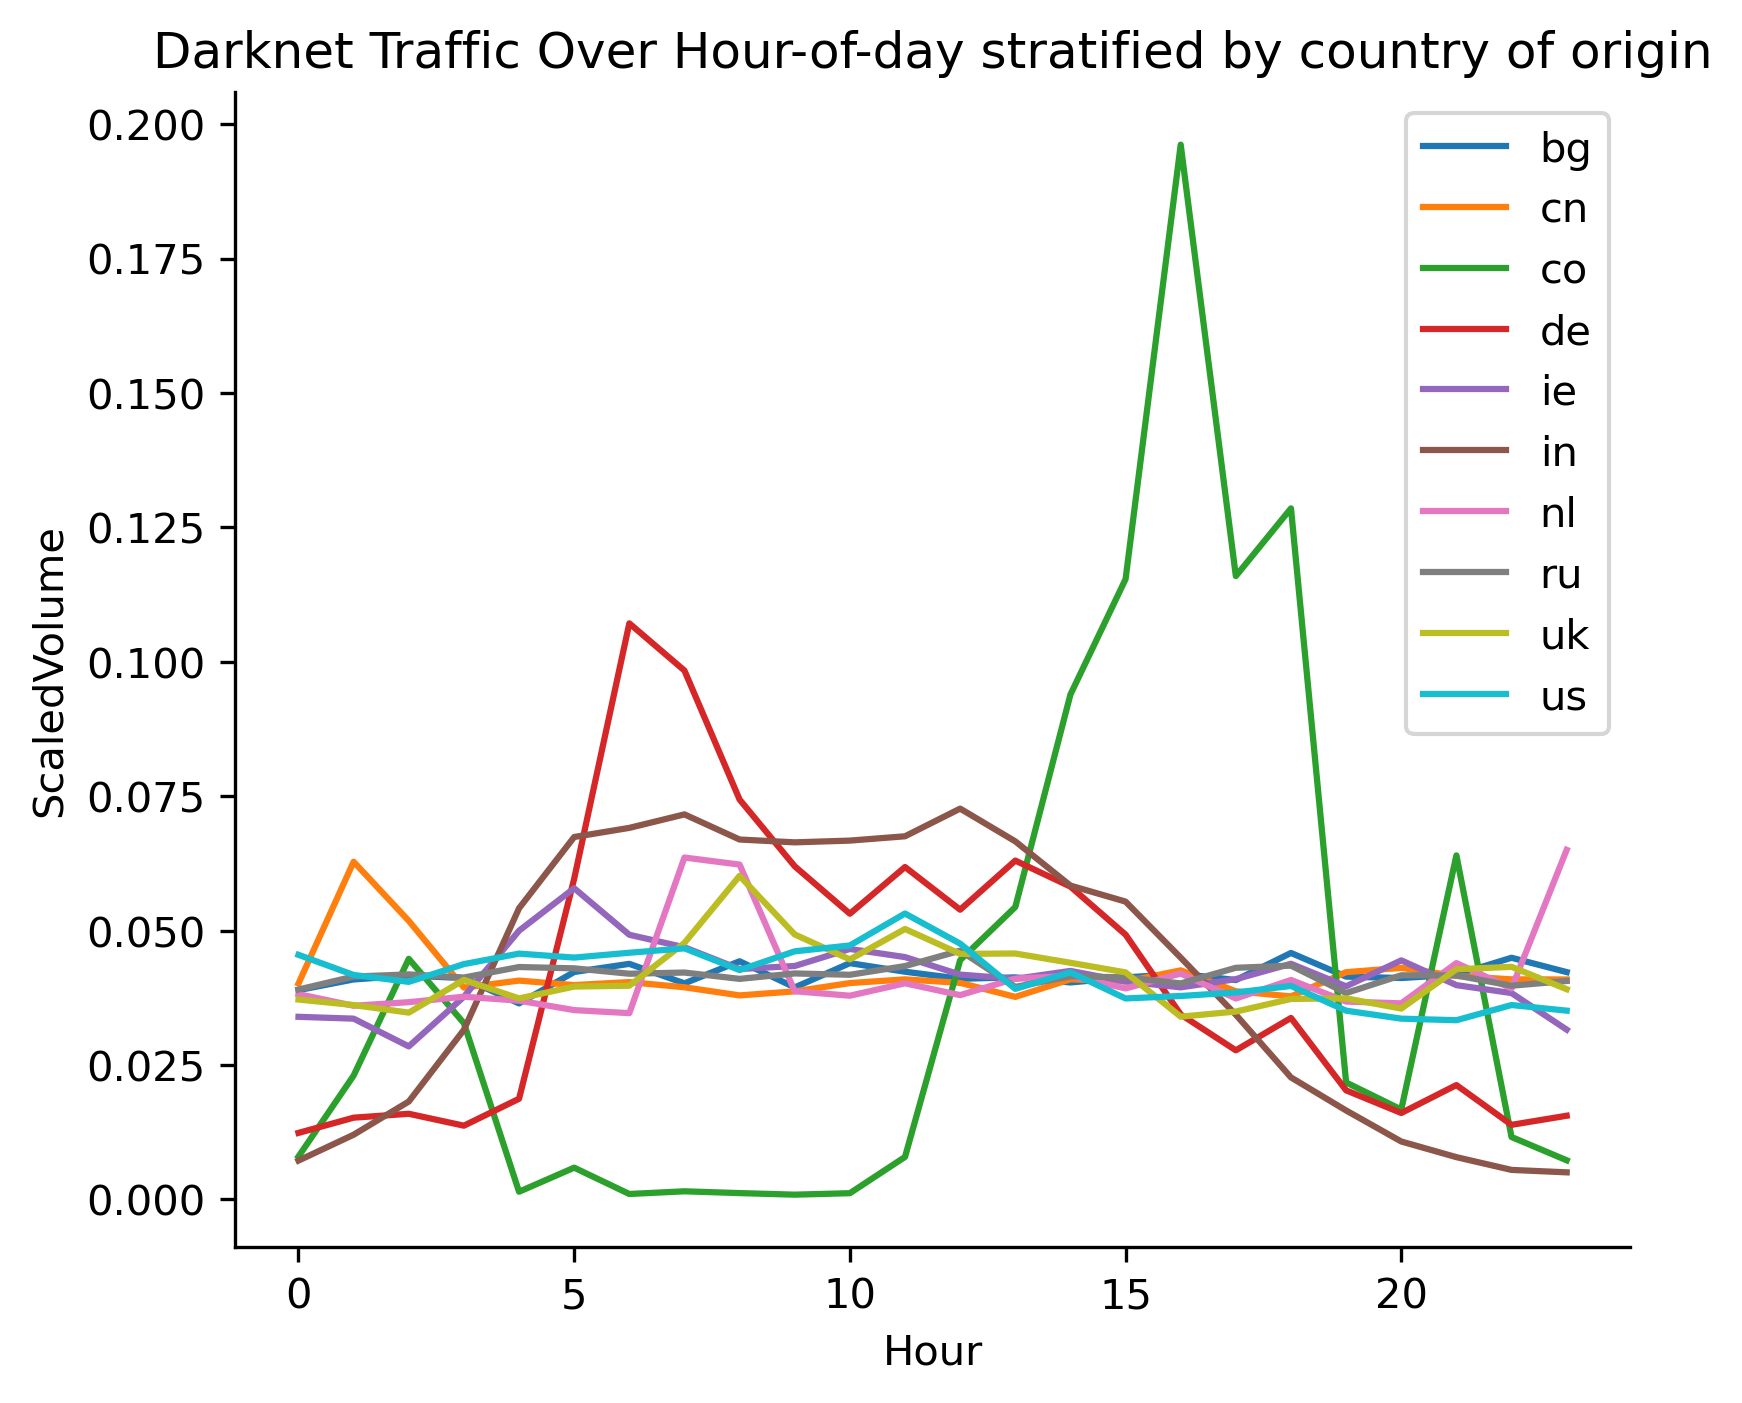

In [75]:
fig, ax = plt.subplots(1,1, figsize=(6,5), dpi=300)


df['Hour'] = df.Date.dt.hour
sns.lineplot(
    data = df,
    x='Hour',
    y='ScaledVolume',
    hue='NetacqCountry',
    estimator='sum',
    errorbar=None,
)

ax.legend(fontsize=10)

ax.set_title('Darknet Traffic Over Hour-of-day stratified by country of origin')
sns.despine()

In [104]:
f(
    df
    .groupby(['NetacqCountry','Hour'])
    .ScaledVolume
    .sum()
    .groupby('NetacqCountry')
    .apply(lambda x: -sum(x * np.log(x)))
    .sort_values()
    .reset_index()
)

\begin{tabular}{lr}
NetacqCountry & ScaledVolume \\
co & 2.510361 \\
in & 2.956710 \\
de & 2.973771 \\
nl & 3.159050 \\
ie & 3.167095 \\
uk & 3.167999 \\
us & 3.170671 \\
cn & 3.171154 \\
bg & 3.176941 \\
ru & 3.177287 \\
\end{tabular}



# Question 3

\begin{tabular}{lrr}
Scanner & Volume (bytes) & Volume (MB) \\
Masscan & 383675774 & 365.901731 \\
ZMap & 122227678 & 116.565397 \\
Mirai & 104116850 & 99.293566 \\
censys-io & 60515145 & 57.711740 \\
shadowserver.org & 16089560 & 15.344200 \\
stretchoid.com & 11537272 & 11.002800 \\
internet-measurement-com & 7648560 & 7.294235 \\
shodan-io & 5998108 & 5.720242 \\
internet-census & 4167915 & 3.974833 \\
Bogon & 32154 & 0.030664 \\
rapid7 & 30720 & 0.029297 \\
\end{tabular}

\begin{tabular}{lr}
Scanner & Unique Protocol-Port pairs \\
censys-io & 64003 \\
internet-measurement-com & 3716 \\
internet-census & 1266 \\
shodan-io & 1259 \\
stretchoid.com & 271 \\
shadowserver.org & 112 \\
Bogon & 3 \\
rapid7 & 2 \\
\end{tabular}

\begin{tabular}{lllrrrr}
 &  &  & Count & Volume & RelativeCount & RelativeVolume \\
Scanner & Protocol & Port &  &  &  &  \\
\multirow[t]{3}{*}{Masscan} & \multirow[t]{3}{*}{TCP} & 3389 & 110207 & 6613584 & 0.003240 & 0.002245 \\
 &  & 2375 & 62448 & 3746880 & 0.00

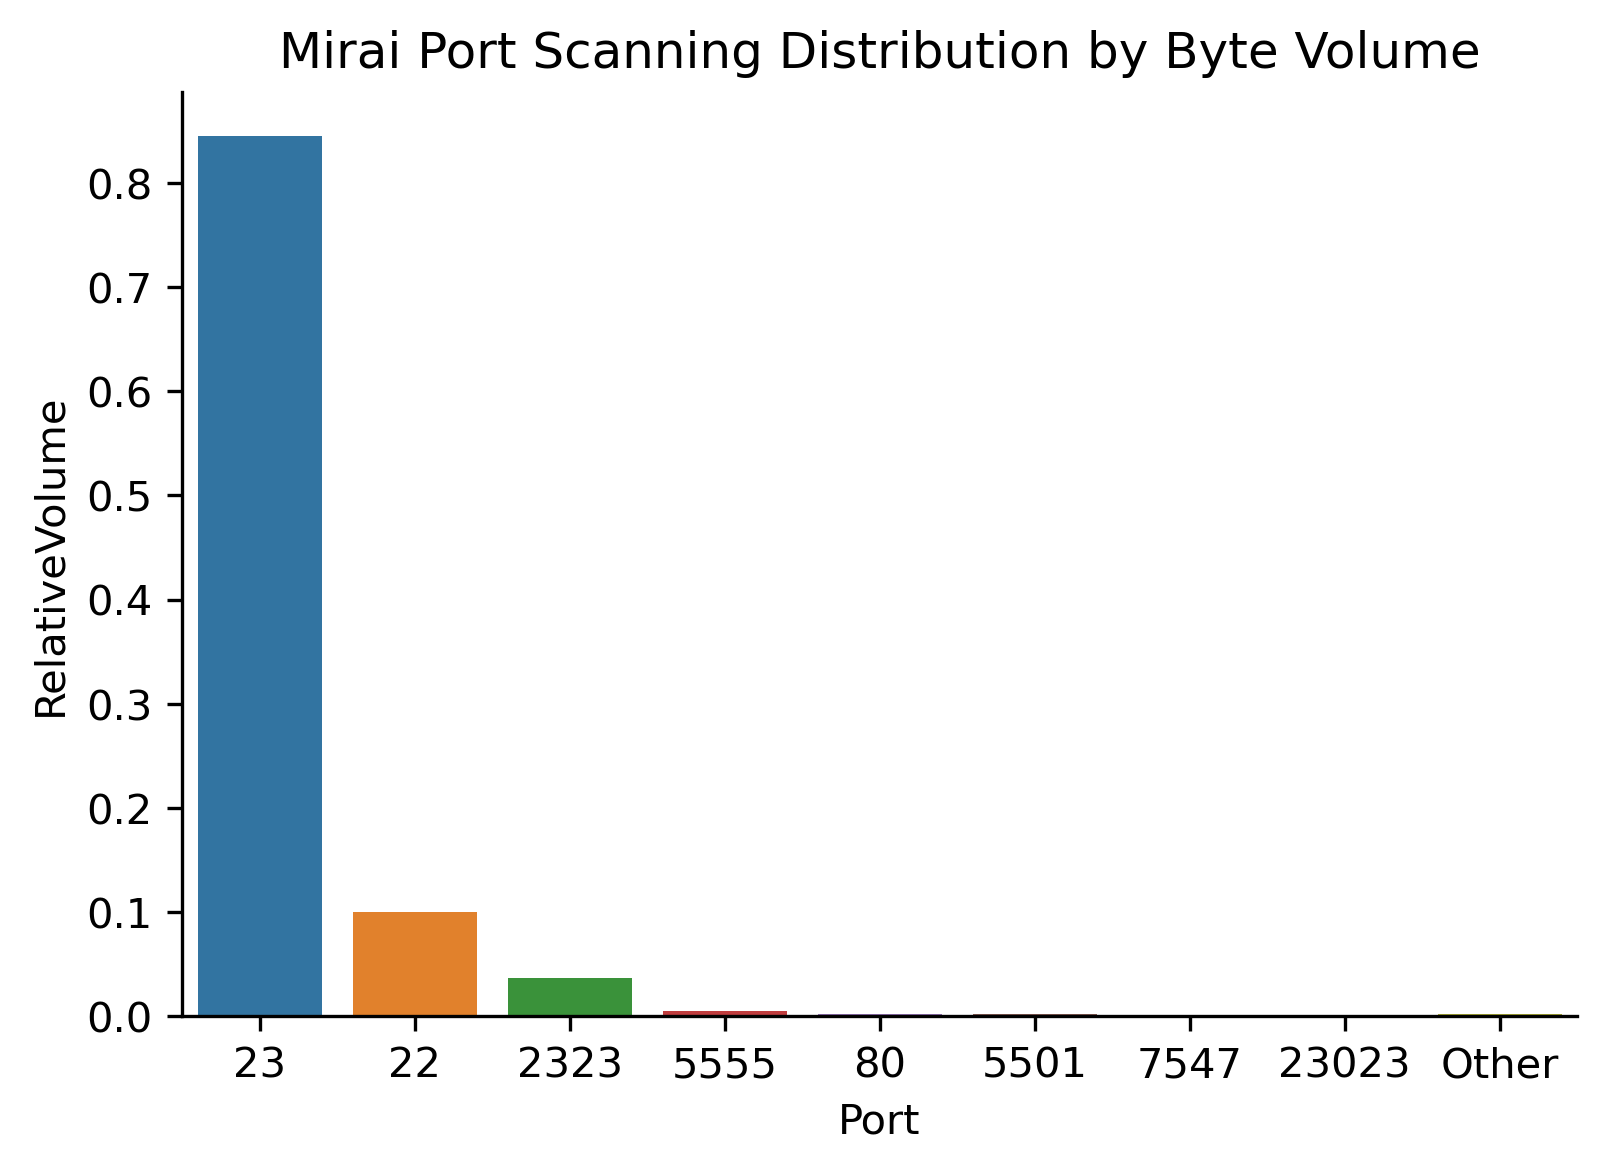

In [133]:
df = pd.read_csv('data/processed/scanning_campaign.csv').dropna()



# part a
f(
    df
    .groupby('Scanner', as_index=False)['Volume']
    .sum()
    .sort_values('Volume', ascending=False)
    .assign(**{"Volume (MB)": lambda x: x.Volume / 2**20})
    .rename(columns={"Volume": "Volume (bytes)"})
    # .set_index('Scanner')
)



# part b
f(
    df
    [~df.Scanner.isin(['Mirai', 'ZMap', 'Masscan'])]
    .groupby('Scanner', as_index=False)
    [['Protocol', 'Port']]
    .size()
    .sort_values('size', ascending=False)
    .rename(columns={'size': 'Unique Protocol-Port pairs'})
    # .set_index('Scanner')
)




print(
    df
    [df.Scanner.isin(['Mirai', 'ZMap', 'Masscan'])]
    .groupby(['Scanner', 'Protocol'])
    .apply(lambda x: x.nlargest(3,'Count'))
    .set_index(['Scanner', 'Protocol', 'Port'])
    .style.to_latex(multirow_align='t')
)



f(
    df[df.Scanner == 'rapid7']
)


fig, axis = plt.subplots(figsize=(6,4), dpi=300)

sns.barplot(
    data = coalesce_into_other(
        df[df.Scanner == 'Mirai'].assign(RelativeVolume = lambda x: x.Volume / x.Volume.sum()),
        8,
        'RelativeVolume', 
        'Port',        
    ),
    x='Port', 
    y='RelativeVolume', 
    orient='v'
)

axis.set_title('Mirai Port Scanning Distribution by Byte Volume')
sns.despine()

In [126]:
print(
    df
    [(df.Scanner.isin(['Mirai', 'ZMap', 'Masscan']))]
    .groupby(['Scanner', 'Protocol'], as_index=True)
    .size()
    # .sort_values('size', ascending=False)
    # .rename(columns={'size': 'Unique Protocol-Port pairs'})
    # .set_index('Scanner')
)

Scanner  Protocol
Masscan  TCP         34488
Mirai    TCP           549
ZMap     TCP          2185
         UDP           192
dtype: int64


In [124]:
print(
    df
    [(~df.Scanner.isin(['Mirai', 'ZMap', 'Masscan']))]
    .groupby(['Scanner', 'Protocol'], as_index=True)
    .size()
    # .sort_values('size', ascending=False)
    # .rename(columns={'size': 'Unique Protocol-Port pairs'})
    # .set_index('Scanner')
    .to_latex()
)

\begin{tabular}{llr}
\toprule
               &     &      0 \\
Scanner & Protocol &        \\
\midrule
Bogon & TCP &      3 \\
censys-io & TCP &  63963 \\
               & UDP &     40 \\
internet-census & TCP &   1240 \\
               & UDP &     26 \\
internet-measurement-com & TCP &   3716 \\
rapid7 & TCP &      2 \\
shadowserver.org & TCP &     81 \\
               & UDP &     31 \\
shodan-io & TCP &   1192 \\
               & UDP &     67 \\
stretchoid.com & TCP &    261 \\
               & UDP &     10 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_20001/1915283062.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  .to_latex()




# Question 4

\begin{tabular}{lrrll}
 & Volume & RelativeVolume & org_name & country \\
ASN &  &  &  &  \\
15169 & 19770575 & 0.294026 & Google LLC & US \\
16509 & 5535576 & 0.082325 & Amazon.com, Inc. & US \\
20940 & 4936170 & 0.073410 & Akamai International B.V. & NL \\
9121 & 4806504 & 0.071482 & Turk Telekomunikasyon Anonim Sirketi & TR \\
32934 & 4033404 & 0.059984 & Facebook, Inc. & US \\
14618 & 3484274 & 0.051818 & Amazon.com, Inc. & US \\
140096 & 2019003 & 0.030026 & Shanghai Huajuan Information Technology Co., Ltd. & CN \\
38193 & 1942780 & 0.028893 & TRANSWORLD ASSOCIATES (PVT) LIMITED & PK \\
396982 & 1650252 & 0.024542 & Google LLC & US \\
48090 & 1587200 & 0.023605 & PPTECHNOLOGY LIMITED & GB \\
\end{tabular}



,dest_ip,ASN,Count,Volume,RelativeCount,RelativeVolume
1,8.8.4.4,15169,30332,1840246,0.000892,0.000625
2,8.8.8.8,15169,25688,1571416,0.000755,0.000533
3,142.250.181.174,15169,17142,1050257,0.000504,0.000356
4,142.250.201.142,15169,16466,1020302,0.000484,0.000346
5,157.240.227.1,32934,13244,848263,0.000389,0.000288
6,45.148.10.81,48090,12800,1320960,0.000376,0.000448
7,185.155.208.1,205607,11729,703740,0.000345,0.000239
8,172.217.18.131,15169,11651,714474,0.000342,0.000243
9,34.107.166.226,15169,10708,706728,0.000315,0.000240
10,157.240.227.61,32934,10102,1023754,0.000297,0.000347


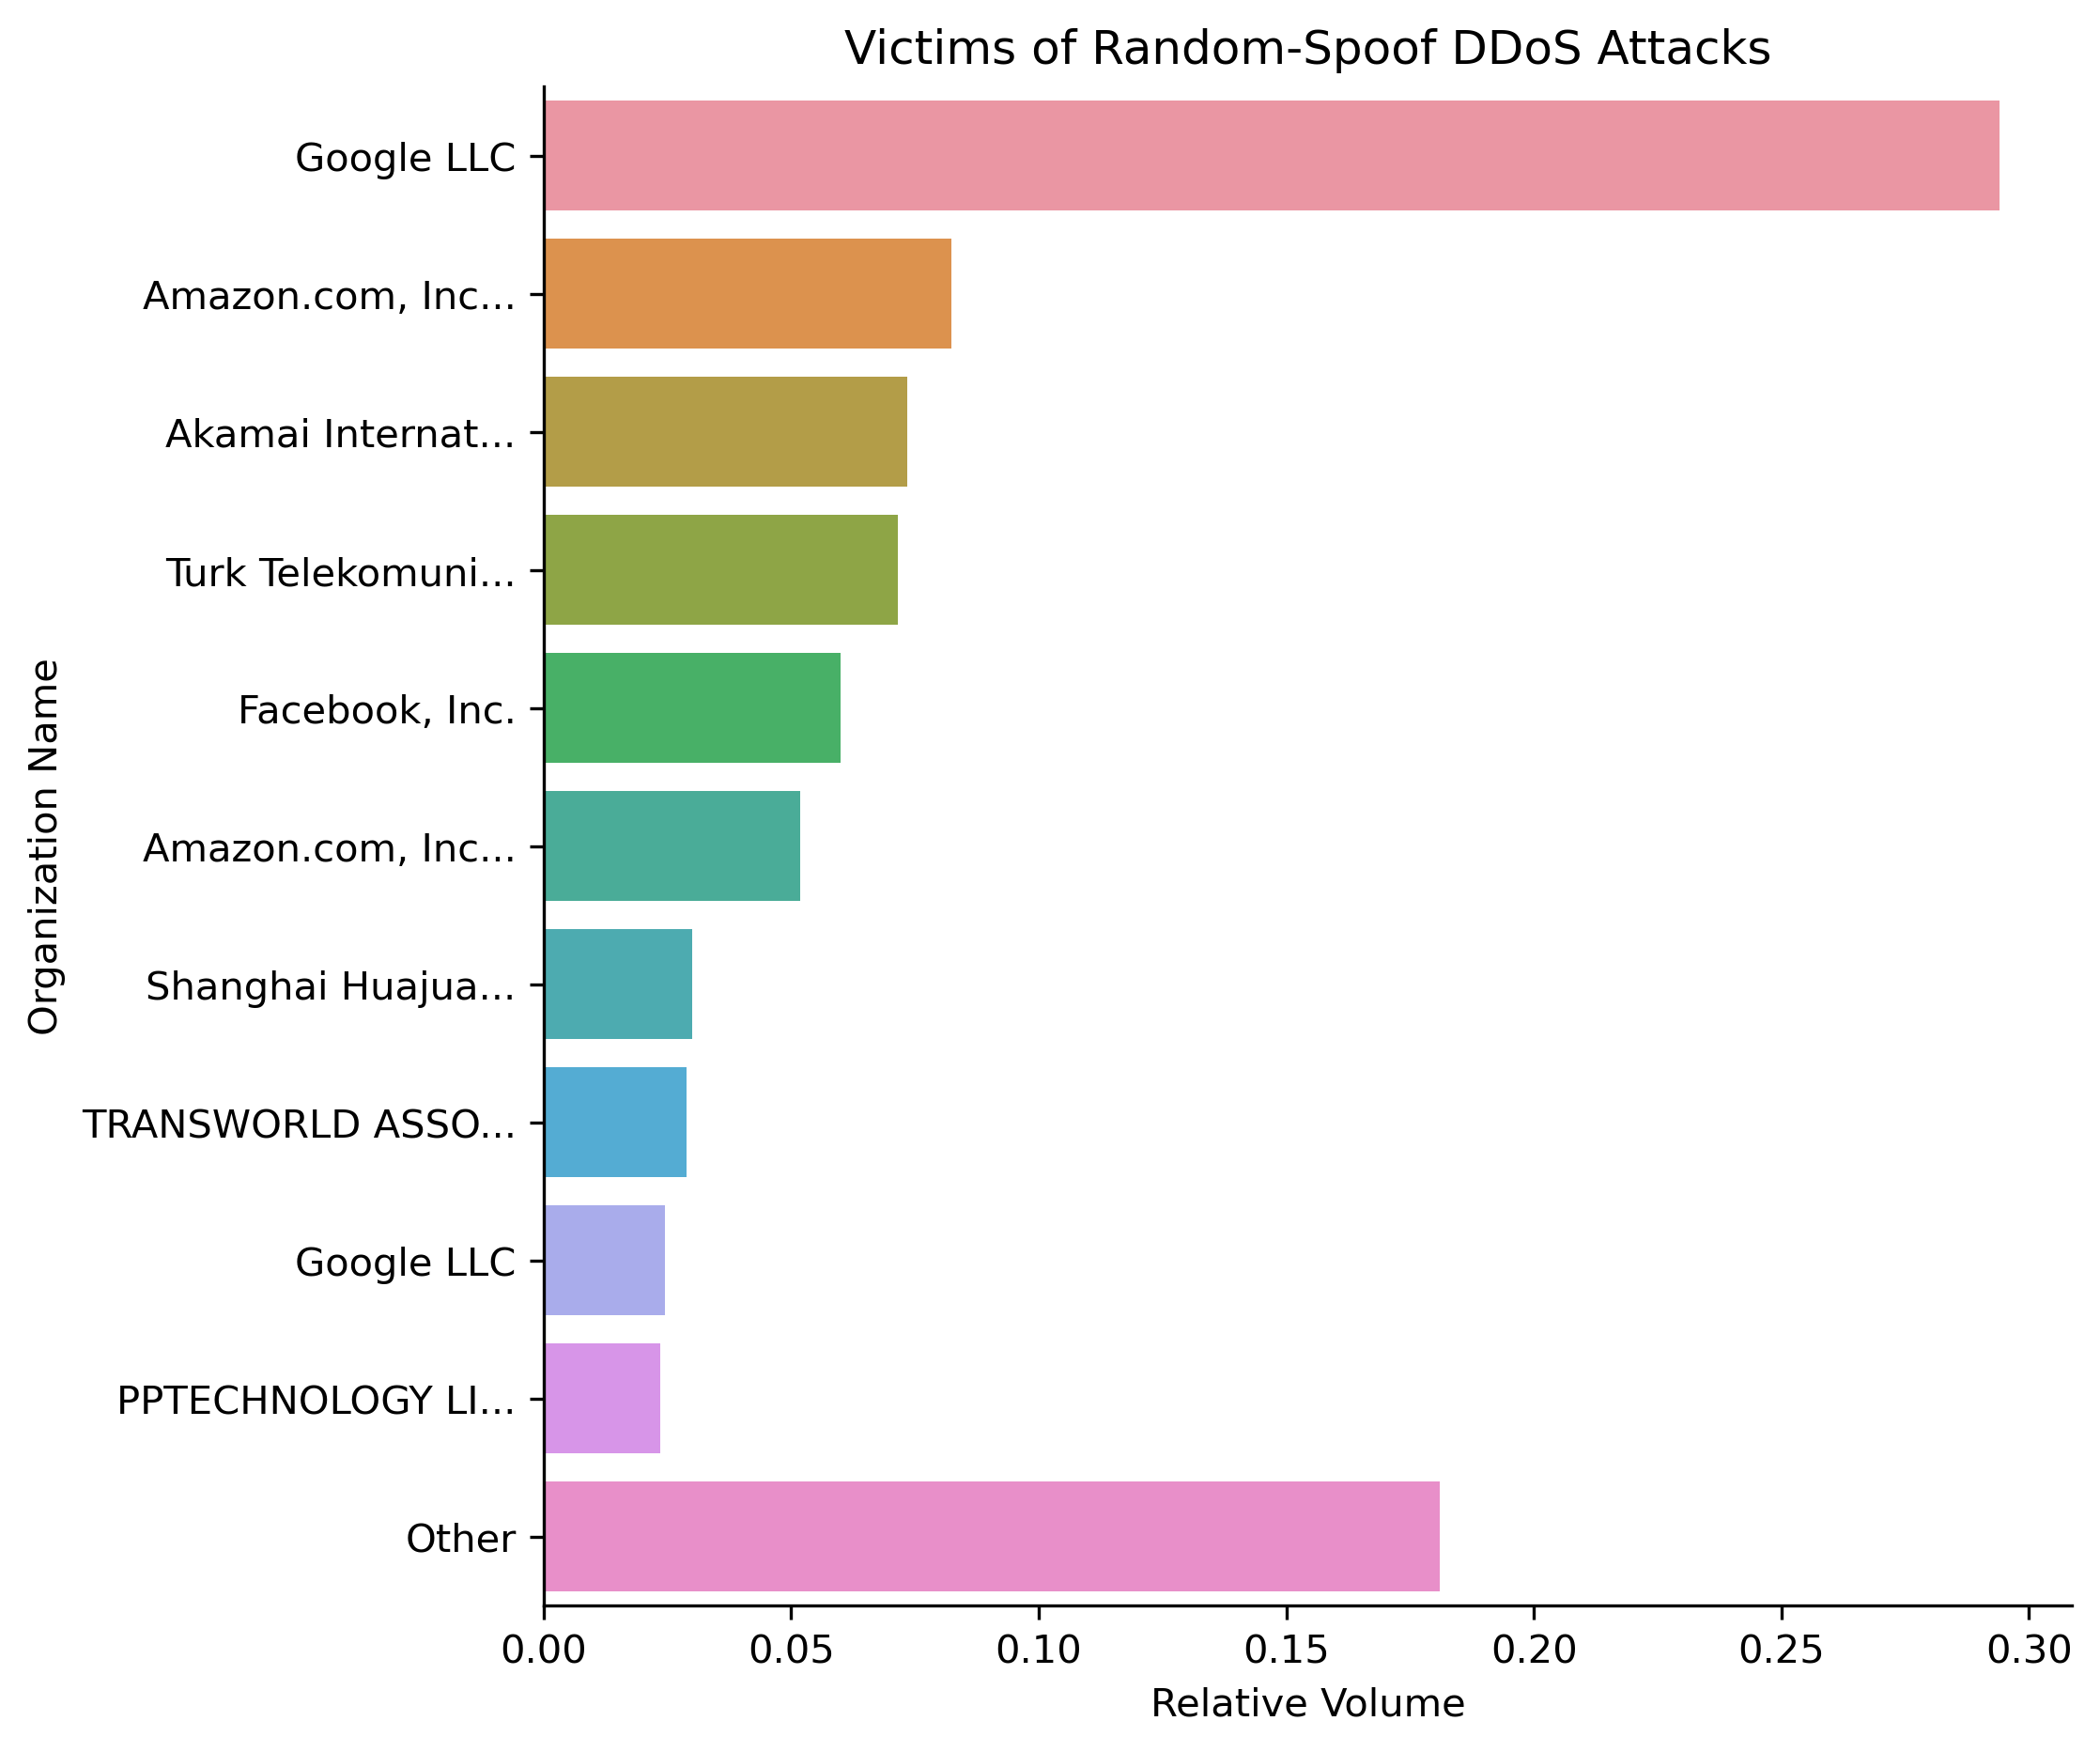

In [12]:

df = pd.read_csv('data/processed/internet_backscatter.csv')

as_numbers = io.StringIO()
as_org = io.StringIO()

with gzip.open('data/20230101.as-org2info.txt.gz') as f:
    while (line:=f.readline().decode('utf-8')):
        if 'format:' in line:
            as_org.write(line.replace('# format:', ''))
            break

    while (line:=f.readline().decode('utf-8')):
        if 'format:' in line:
            as_numbers.write(line.replace('# format:', ''))
            break
        as_org.write(line)

    while (line:=f.readline().decode('utf-8')):
        as_numbers.write(line)

    as_org.seek(0)
    as_numbers.seek(0)

as_orgs = pd.read_csv(as_org, delimiter='|')
as_numbers = pd.read_csv(as_numbers, delimiter='|')

as_org_data = as_orgs.merge(as_numbers, on='org_id', suffixes=['_org', '_number'])

grouped_df = df.groupby('ASN')[['Count', 'Volume']].sum().reset_index()
grouped_df['ASN'] = grouped_df['ASN'].astype(int)
grouped_df['RelativeCount'] = grouped_df['Count'] /  grouped_df['Count'].sum()
grouped_df['RelativeVolume'] = grouped_df['Volume'] /  grouped_df['Volume'].sum()

merged_df = grouped_df.merge(as_org_data, left_on='ASN', right_on='aut')

print(
    merged_df
    .sort_values('RelativeVolume', ascending=False)[:10]
    .set_index('ASN')
    [['Volume', 'RelativeVolume', 'org_name', 'country']]
    .style.to_latex()
)

fig, ax = plt.subplots(figsize=(7,7), dpi=300)
sns.barplot(
    data = coalesce_into_other(merged_df, 10, 'RelativeVolume', 'org_name', 'ASN'), 
    # data = grouped_df.sort_values('RelativeVolume', ascending=False).iloc[:10], 
    y='ASN', 
    x='RelativeVolume',     
)

name_len = 15
ax.set_yticklabels([
    org[:name_len] + ('...' if len(org) > name_len else '') 
    for org 
    in coalesce_into_other(merged_df, 10, 'RelativeVolume', 'org_name', 'ASN').org_name.to_list()
])

ax.set_ylabel('Organization Name')
ax.set_xlabel('Relative Volume')

ax.set_title('Victims of Random-Spoof DDoS Attacks')

sns.despine()

df.dropna()[:10]